In [ ]:
!pip install tensorflow==2.12.0
!pip install keras==2.12.0
!pip install tensorflow-addons==0.19.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Un

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

(X_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 18s 0us/step
X_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
lr = 0.001
batch_size = 256
epochs = 25
weight_decay = 0.0001
image_size = 72
patch_size = 6
num_heads = 4
projection_dim = 64
num_patches = (image_size // patch_size) ** 2
transformer_units = [
    projection_dim * 2,
    projection_dim
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2)
    ],
    name="data_augmentation"
)

data_augmentation.layers[0].adapt(X_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
      batch_size = tf.shape(images)[0]
      patches = tf.image.extract_patches(
          images=images,
          sizes=[1, self.patch_size, self.patch_size, 1],
          strides=[1, self.patch_size, self.patch_size, 1],
          rates=[1, 1, 1, 1],
          padding="VALID"
      )
      patch_dims = patches.shape[-1]
      patches = tf.reshape(patches, [batch_size, -1, patch_dims])
      return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per image: 108


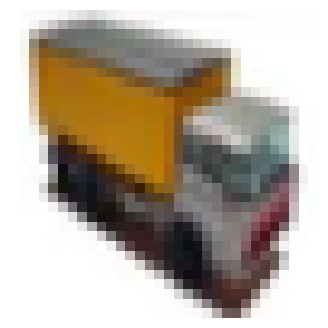

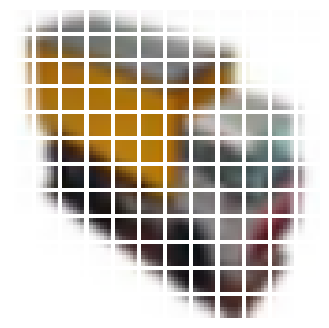

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per image: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )
    def call(self, patch):
      positions = tf.range(start=0, limit=self.num_patches, delta=1)
      encoded = self.projection(patch) + self.position_embedding(positions)
      return encoded

In [ ]:
def create_vit_classifier():
  inputs = layers.Input(shape=input_shape)
  # Augment data
  augmented = data_augmentation(inputs)
  # Create patches
  patches = Patches(patch_size)(augmented)
  # Encode patches
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  # Create multiple layers of the Transformer block
  for _ in range(transformer_layers):
    # Layer normalization
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    # Create a multi-head attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)

    # Skip connection 1
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

    # MLP
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

    # Skip connection 2
    # Ensure x3 and x2 have the same shape before adding
    x3 = layers.Dense(x2.shape[-1])(x3)  # Adjust x3's dimension to match x2
    encoded_patches = layers.Add()([x3, x2])

  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

  # Calculate the output shape of the representation
  output_shape = (num_patches, projection_dim)

  # Add a Reshape layer to explicitly define the shape
  representation = layers.Reshape(output_shape)(representation)

  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)

  # Add MLP
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

  # Classify outputs
  logits = layers.Dense(num_classes)(features)

  # Create the keras model
  model = keras.Model(inputs=inputs, outputs=logits)
  return model

In [ ]:
def create_vit_classifier():
  inputs = layers.Input(shape=input_shape)
  # Augment data
  augmented = data_augmentation(inputs)
  # Create patches
  patches = Patches(patch_size)(augmented)
  # Encode patches
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  # Create multiple layers of the Transformer block
  for _ in range(transformer_layers):
    # Layer normalization
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    # Create a multi-head attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)

    # Skip connection 1
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

    # MLP
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

    # Skip connection 2
    # Ensure x3 and x2 have the same shape before adding
    x3 = layers.Dense(x2.shape[-1])(x3)  # Adjust x3's dimension to match x2
    encoded_patches = layers.Add()([x3, x2])

  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

  # Remove the reshape and flatten layers
  #representation = layers.Reshape(output_shape)(representation)
  #representation = layers.Flatten()(representation)

  representation = layers.Dropout(0.5)(representation)

  # Add MLP
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

  # Apply GlobalAveragePooling1D to aggregate the representations
  features = layers.GlobalAveragePooling1D()(features)

  # Classify outputs
  logits = layers.Dense(num_classes)(features)

  # Create the keras model
  model = keras.Model(inputs=inputs, outputs=logits)
  return model

In [ ]:
def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(
      learning_rate=lr, weight_decay=weight_decay)

  model.compile(
      optimizer=optimizer,
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[
          keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
          keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
      ],
  )
  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True
  )
  history = model.fit(
      x=X_train[:10000],
      y=y_train[:10000],
      batch_size=batch_size,
      epochs=epochs,
      validation_split=0.1,
      callbacks=[checkpoint_callback]
  )

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test[:10000], y_test[:10000])
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

In [ ]:
class_names = ['cat', 'airplane', 'automobile', 'bird', 'bus', 'truck', 'deer', 'dog', 'frog', 'horse', 'ship']

In [ ]:
def img_predict(images, model):
  if len(images.shape) == 3:
    out = model.predict(images.reshape(-1, *image.shape))

  else:
    out = model.predict(images)
  prediction = np.argmax(out, axis=1)
  img_prediction = [class_names[i] for i in prediction]
  return img_prediction

In [ ]:
index = 14
plt.imshow(x_test[index])
prediction = img_predict(x_test[index], vit_classifier)
print(f"Prediction: {prediction}")